## Load data from kaggle

In [ ]:
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

100% 779M/779M [00:23<00:00, 39.5MB/s]
100% 779M/779M [00:23<00:00, 34.2MB/s]


In [ ]:
!unzip -q /content/plant-pathology-2020-fgvc7.zip

In [ ]:
!pip -q install tensorflow
!pip install -q keras

# Data preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.xception  import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
SEED = 2007
BATCH_SIZE = 64
TARGET = ['healthy', 'multiple_diseases',	'rust',	'scab']


np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [ ]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [ ]:
test_df['image_path'] = '/content/images/' + test_df['image_id'] + '.jpg'
train_df['image_path'] = '/content/images/' + train_df['image_id'] + '.jpg'

In [ ]:
n_train = int(len(train_df)*0.8)

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_ds = train_gen.flow_from_dataframe(train_df.iloc[:n_train, :],
                                         x_col='image_path',
                                         y_col=TARGET,
                                         class_mode='raw',
                                         batch_size=BATCH_SIZE,
                                         seed=SEED)
val_ds = test_gen.flow_from_dataframe(train_df.iloc[n_train:, :],
                                      x_col='image_path',
                                      y_col=TARGET,
                                      class_mode='raw',
                                      batch_size=BATCH_SIZE,
                                      seed=SEED,
                                      shuffle=False)
test_ds = test_gen.flow_from_dataframe(test_df, x_col='image_path',
                                        class_mode=None,
                                        batch_size=BATCH_SIZE,
                                        seed=SEED,
                                        shuffle=False)

Found 1456 validated image filenames.
Found 365 validated image filenames.
Found 1821 validated image filenames.


# Train

## Transfer-learning

In [ ]:
base_model = Xception(weights='imagenet', input_shape=(150,150,3), include_top=False)
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(150,150,3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_____________________________________________

In [ ]:
n_epoch = 10
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(train_ds, epochs=n_epoch, validation_data=val_ds)

Epoch 1/10
23/23 [==============================] - 78s 3s/step - loss: 1.0972 - categorical_accuracy: 0.5385 - val_loss: 0.9749 - val_categorical_accuracy: 0.6548
Epoch 2/10
23/23 [==============================] - 67s 3s/step - loss: 0.8595 - categorical_accuracy: 0.6985 - val_loss: 0.8758 - val_categorical_accuracy: 0.6658
Epoch 3/10
23/23 [==============================] - 63s 3s/step - loss: 0.7706 - categorical_accuracy: 0.7232 - val_loss: 0.8173 - val_categorical_accuracy: 0.7014
Epoch 4/10
23/23 [==============================] - 69s 3s/step - loss: 0.7172 - categorical_accuracy: 0.7411 - val_loss: 0.7673 - val_categorical_accuracy: 0.7397
Epoch 5/10
23/23 [==============================] - 59s 3s/step - loss: 0.6865 - categorical_accuracy: 0.7507 - val_loss: 0.7635 - val_categorical_accuracy: 0.7123
Epoch 6/10
23/23 [==============================] - 62s 3s/step - loss: 0.6505 - categorical_accuracy: 0.7617 - val_loss: 0.7142 - val_categorical_accuracy: 0.7644
Epoch 7/10
23/23

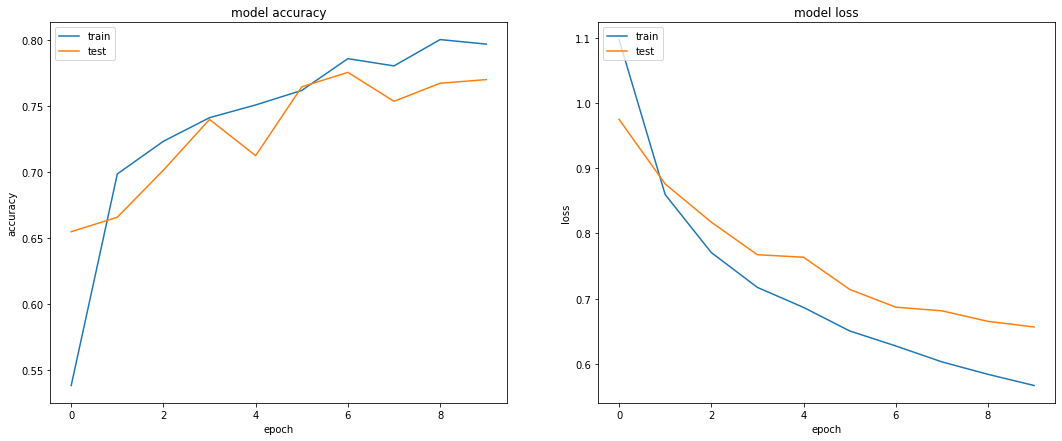

In [ ]:
def plot_history(history):
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_history(history)

In [ ]:
val_acc = history.history['val_categorical_accuracy'][-1]
print('Validation accuracy: %.3f' % val_acc)

Validation accuracy: 0.770


## Fine-tuning

In [ ]:
base_model.trainable=True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
23/23 [==============================] - 85s 3s/step - loss: 0.4833 - categorical_accuracy: 0.8235 - val_loss: 0.4878 - val_categorical_accuracy: 0.8356
Epoch 2/10
23/23 [==============================] - 71s 3s/step - loss: 0.3192 - categorical_accuracy: 0.8839 - val_loss: 0.4280 - val_categorical_accuracy: 0.8548
Epoch 3/10
23/23 [==============================] - 72s 3s/step - loss: 0.2306 - categorical_accuracy: 0.9121 - val_loss: 0.4149 - val_categorical_accuracy: 0.8685
Epoch 4/10
23/23 [==============================] - 74s 3s/step - loss: 0.1739 - categorical_accuracy: 0.9382 - val_loss: 0.4087 - val_categorical_accuracy: 0.8712
Epoch 5/10
23/23 [==============================] - 74s 3s/step - loss: 0.1274 - categorical_accuracy: 0.9581 - val_loss: 0.3935 - val_categorical_accuracy: 0.8712
Epoch 6/10
23/23 [==============================] - 74s 3s/step - loss: 0.0810 - categorical_accuracy: 0.9773 - val_loss: 0.3754 - val_categorical_accuracy: 0.8849
Epoch 7/10
23/23

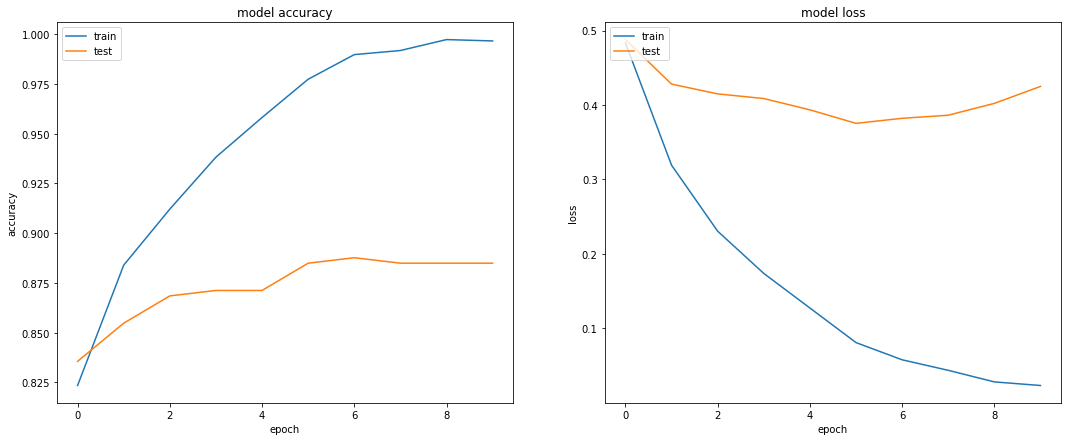

In [ ]:
plot_history(history)

# Predict

In [ ]:
pred = model.predict(test_ds)

29/29 [==============================] - 63s 2s/step


In [ ]:
submission = pd.DataFrame(pred, columns=TARGET, index=test_df['image_id'])
submission.index.name = 'image_id'
submission.to_csv('submission.csv')

**Final score is ~0.89.**